In [3]:
import numpy as np
import pandas as pd
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [4]:
import os
import random
from glob import glob
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, ResNet152V2, MobileNetV2, Xception
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# from keras_tuner.tuners import Hyperband
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
train_data_dir = 'AGRO/train'
test_data_dir = 'AGRO/test'

In [7]:
img_width, img_height = 224, 224
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [10]:
aug_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1265 images belonging to 15 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 314 images belonging to 15 classes.


In [13]:
num_classes = len(train_generator.class_indices)

num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

print("Number of classes:", num_classes)
print("Number of training samples:", num_train_samples)
print("Number of test samples:", num_test_samples)


Number of classes: 15
Number of training samples: 1265
Number of test samples: 314


In [14]:
# inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
# print(validation_generator.class_indices)
# print(inv_map_classes)

In [15]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_data_dir)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_data_dir)):
        image_ids = os.listdir(os.path.join(train_data_dir,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = plt.imread(os.path.join(train_data_dir,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

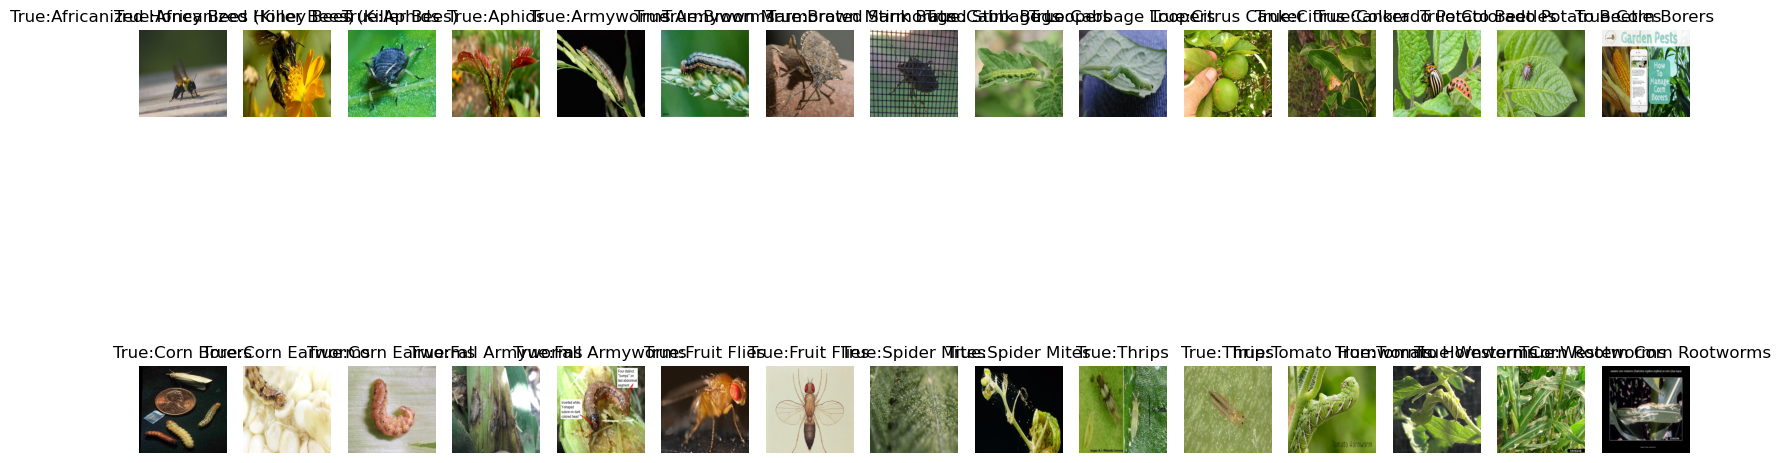

In [16]:
show_few_images(2)

In [17]:
tf.keras.backend.clear_session()

In [16]:
# import os

# root_dir = 'AGRO'

# train_dir = os.path.join(root_dir, 'AGRO', 'train')
# # validation_dir = os.path.join(root_dir, 'AGRO', 'validation')
# test_dir = os.path.join(root_dir, 'AGRO', 'test')

# train_labels = []
# train_image_paths = []
# validation_labels = []
# validation_image_paths = []
# test_labels = []
# test_image_paths = []

# # Define a function to create labels and image paths from a directory
# def create_labels_and_paths(directory, label):
#     for class_dir in os.listdir(directory):
#         if os.path.isdir(os.path.join(directory, class_dir)):
#             class_label = label  # Use the provided label for this dataset
#             class_path = os.path.join(directory, class_dir)

#             for image_file in os.listdir(class_path):
#                 if image_file.endswith('.jpg'):
#                     image_path = os.path.join(class_path, image_file)

#                     if label == 'train':
#                         train_labels.append(class_label)
#                         train_image_paths.append(image_path)
#                     # elif label == 'validation':
#                     #     validation_labels.append(class_label)
#                     #     validation_image_paths.append(image_path)
#                     elif label == 'test':
#                         test_labels.append(class_label)
#                         test_image_paths.append(image_path)

# # Create labels and image paths for each dataset
# create_labels_and_paths(train_dir, label='train')
# # create_labels_and_paths(validation_dir, label='validation')
# create_labels_and_paths(test_dir, label='test')

# # Now, you have labels and corresponding image paths for your train, validation, and test datasets.


In [40]:
import keras
from keras.callbacks import Callback

class ReduceLRonDrop(Callback):
    def __init__(self, factor=0.2, threshold=0.05, patience=3, optimizer=None):
        super(ReduceLRonDrop, self).__init__()
        self.factor = factor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0
        self.optimizer = optimizer  

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0:
            if 'accuracy' in logs:
                accuracy_key = 'accuracy'
            elif 'acc' in logs:
                accuracy_key = 'acc'
            else:
                raise ValueError("Could not find accuracy key in logs.")

            acc_diff = logs[accuracy_key] - self.prev_accuracy
            if acc_diff < -self.threshold:
                lr = float(keras.backend.get_value(self.optimizer.lr))
                new_lr = lr * self.factor
                keras.backend.set_value(self.optimizer.lr, new_lr)
                print(f'Reducing learning rate to {new_lr:.6f} due to accuracy drop.')
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.wait = 0
                    lr = float(keras.backend.get_value(self.optimizer.lr))
                    new_lr = lr * self.factor
                    keras.backend.set_value(self.optimizer.lr, new_lr)
                    print(f'Reducing learning rate to {new_lr:.6f} due to patience.')

        self.prev_accuracy = logs[accuracy_key]

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [41]:
def save_history(history, model_name):
    hist_df = pd.DataFrame(history.history)

    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
#         val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
#         val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
#     sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(epochs, loss,label='Training Loss')
#     sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [42]:
batch_size=32

In [43]:
CNN_epoch = 20
vgg_epoch = 20
resnet_epoch = 20
xception_epoch = 20
mobilenet_epoch = 20

In [21]:
optimizer = Adam(learning_rate=0.0001)

**CNN**

In [22]:
# CNN_model = Sequential()
# CNN_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# CNN_model.add(MaxPooling2D((2, 2)))
# CNN_model.add(Conv2D(512, (3, 3), activation='relu'))
# CNN_model.add(MaxPooling2D((2, 2)))
# CNN_model.add(Conv2D(256, (3, 3), activation='relu'))
# CNN_model.add(MaxPooling2D((2, 2)))
# CNN_model.add(Flatten())
# CNN_model.add(Dense(256, activation='relu'))
# CNN_model.add(Dense(512, activation='relu'))
# CNN_model.add(Dense(128, activation='relu'))
# CNN_model.add(Dense(15, activation='softmax'))

In [23]:
# CNN_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# CNN_history = CNN_model.fit(train_generator, epochs=CNN_epoch, batch_size=batch_size, verbose=1,
#                     callbacks=[reduce_lr_on_drop])

In [25]:
# CNN_model.save('CNN_model.keras')

In [26]:
# do_history_stuff(CNN_history, 'CNN_model')

**VGG**

In [27]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(512, activation = 'relu')(vgg_x)
vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(15, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [28]:
# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,callbacks=[reduce_lr_on_drop],verbose=1)

Epoch 1/20
40/40 [==============================] - 85s 2s/step - loss: 2.6744 - acc: 0.1225
Epoch 2/20
40/40 [==============================] - 85s 2s/step - loss: 2.4191 - acc: 0.2435
Epoch 3/20
40/40 [==============================] - 85s 2s/step - loss: 2.2073 - acc: 0.2941
Epoch 4/20
40/40 [==============================] - 86s 2s/step - loss: 2.0131 - acc: 0.3636
Epoch 5/20
40/40 [==============================] - 85s 2s/step - loss: 1.8829 - acc: 0.4126
Epoch 6/20
40/40 [==============================] - 86s 2s/step - loss: 1.7490 - acc: 0.4538
Epoch 7/20
40/40 [==============================] - 85s 2s/step - loss: 1.6297 - acc: 0.4957
Epoch 8/20
40/40 [==============================] - 85s 2s/step - loss: 1.5252 - acc: 0.5257
Epoch 9/20
40/40 [==============================] - 86s 2s/step - loss: 1.4998 - acc: 0.5233
Epoch 10/20
40/40 [==============================] - 86s 2s/step - loss: 1.3501 - acc: 0.5802
Epoch 11/20
40/40 [==============================] - 86s 2s/step - lo

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


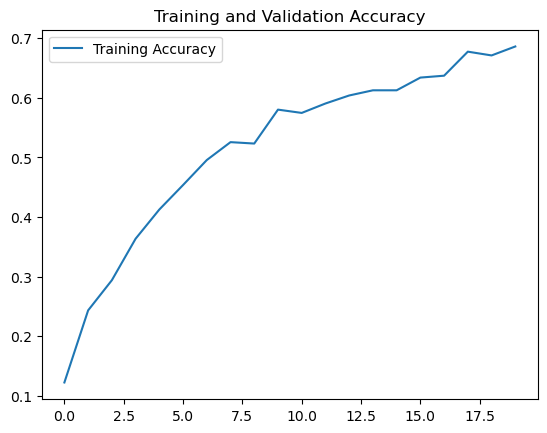

<Figure size 640x480 with 0 Axes>

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


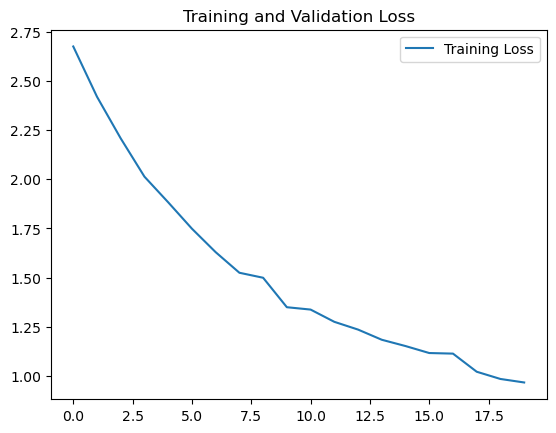

<Figure size 640x480 with 0 Axes>

In [33]:
do_history_stuff(vgg16_history, 'vgg16_model')
vgg16_final_model.save('VGG_model.keras')

**RES-NET-50**

In [51]:
import keras
from keras.callbacks import Callback

class ReduceLRonDrop(Callback):
    def __init__(self, factor=0.2, threshold=0.05, patience=3, optimizer=None):
        super(ReduceLRonDrop, self).__init__()
        self.factor = factor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0
        self.optimizer = optimizer  # Pass the optimizer when initializing the callback
        self.accuracy_key = None  # Initialize accuracy_key

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0:
            if 'accuracy' in logs:
                self.accuracy_key = 'accuracy'
            elif 'acc' in logs:
                self.accuracy_key = 'acc'
            else:
                raise ValueError("Could not find accuracy key in logs.")

            acc_diff = logs[self.accuracy_key] - self.prev_accuracy
            if acc_diff < -self.threshold:
                lr = float(keras.backend.get_value(self.optimizer.lr))
                new_lr = lr * self.factor
                keras.backend.set_value(self.optimizer.lr, new_lr)
                print(f'Reducing learning rate to {new_lr:.6f} due to accuracy drop.')
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.wait = 0
                    lr = float(keras.backend.get_value(self.optimizer.lr))
                    new_lr = lr * self.factor
                    keras.backend.set_value(self.optimizer.lr, new_lr)
                    print(f'Reducing learning rate to {new_lr:.6f} due to patience.')

        self.prev_accuracy = logs[self.accuracy_key]

# Now you can proceed with the training as before

In [52]:
resnet50_reduce_lr_on_drop = ReduceLRonDropResNet50(factor=0.2, threshold=0.05, patience=3, optimizer=optimizer)

In [54]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.optimizers import Adam as LegacyAdam  # Import the legacy optimizer
import tensorflow as tf

ResNet50_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in ResNet50_model.layers:
    layer.trainable = True

ResNet50_last_output = ResNet50_model.output
ResNet50_maxpooled_output = Flatten()(ResNet50_last_output)
ResNet50_x = Dense(512, activation='relu')(ResNet50_maxpooled_output)
ResNet50_x = Dense(1024, activation='relu')(ResNet50_x)
ResNet50_x = Dropout(0.5)(ResNet50_x)
ResNet50_x = Dense(15, activation='softmax')(ResNet50_x)

ResNet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=ResNet50_x)



number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50_' + '-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'


optimizer = LegacyAdam(learning_rate=0.0001) 
ResNet50_x_final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = ResNet50_x_final_model.fit(train_generator, epochs=number_of_epochs, verbose=1)

Epoch 1/20
40/40 [==============================] - 215s 5s/step - loss: 2.8624 - accuracy: 0.2300
Epoch 2/20
40/40 [==============================] - 211s 5s/step - loss: 1.6172 - accuracy: 0.5028
Epoch 3/20
40/40 [==============================] - 211s 5s/step - loss: 1.1751 - accuracy: 0.6340
Epoch 4/20
40/40 [==============================] - 211s 5s/step - loss: 0.8600 - accuracy: 0.7289
Epoch 5/20
40/40 [==============================] - 209s 5s/step - loss: 0.7130 - accuracy: 0.7644
Epoch 6/20
40/40 [==============================] - 208s 5s/step - loss: 0.5731 - accuracy: 0.8040
Epoch 7/20
40/40 [==============================] - 209s 5s/step - loss: 0.4379 - accuracy: 0.8490
Epoch 8/20
40/40 [==============================] - 211s 5s/step - loss: 0.3503 - accuracy: 0.8909
Epoch 9/20
40/40 [==============================] - 214s 5s/step - loss: 0.3002 - accuracy: 0.8957
Epoch 10/20
40/40 [==============================] - 212s 5s/step - loss: 0.2958 - accuracy: 0.9036
Epoch 11/

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


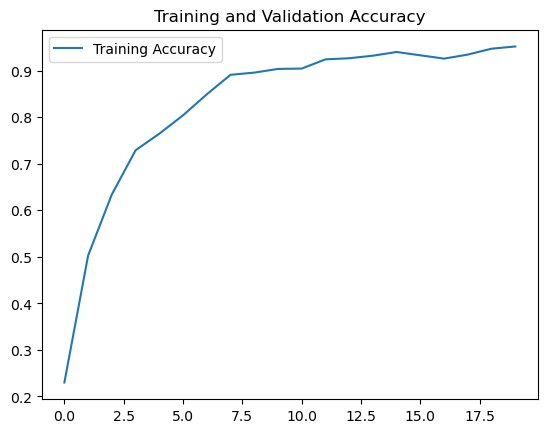

<Figure size 640x480 with 0 Axes>

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


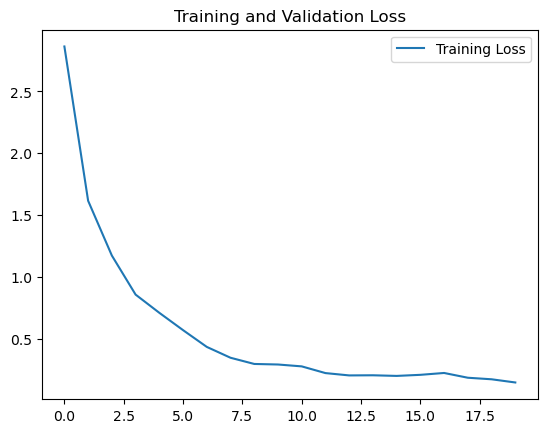

<Figure size 640x480 with 0 Axes>

In [55]:
do_history_stuff(resnet_history, 'resnet50_model', True)
ResNet50_x_final_model.save('ResNet50.keras')

**MobileNetV2**

In [57]:
MobileNetV2_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in MobileNetV2_model.layers:
    layer.trainable = True

MobileNetV2_last_output = MobileNetV2_model.output
MobileNetV2_maxpooled_output = Flatten()(MobileNetV2_last_output)
MobileNetV2_x = Dense(512, activation='relu')(MobileNetV2_maxpooled_output)
MobileNetV2_x = Dense(1024, activation='relu')(MobileNetV2_x)
MobileNetV2_x = Dropout(0.5)(MobileNetV2_x)
MobileNetV2_x = Dense(15, activation='softmax')(MobileNetV2_x)

MobileNetV2_x_final_model = Model(inputs=MobileNetV2_model.input, outputs=MobileNetV2_x)

MobileNetV2_x_final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

number_of_epochs = mobilenet_epoch
mobilenet_filepath = 'mobilenetv2_' + '-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

mobilenet_checkpoint = tf.keras.callbacks.ModelCheckpoint(mobilenet_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
mobilenet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

mobilenet_history = MobileNetV2_x_final_model.fit(train_generator, epochs = number_of_epochs,verbose=1)

Epoch 1/20
40/40 [==============================] - 79s 2s/step - loss: 2.6321 - accuracy: 0.2822
Epoch 2/20
40/40 [==============================] - 75s 2s/step - loss: 1.3752 - accuracy: 0.5715
Epoch 3/20
40/40 [==============================] - 76s 2s/step - loss: 1.0088 - accuracy: 0.6767
Epoch 4/20
40/40 [==============================] - 77s 2s/step - loss: 0.7855 - accuracy: 0.7407
Epoch 5/20
40/40 [==============================] - 79s 2s/step - loss: 0.6102 - accuracy: 0.7960
Epoch 6/20
40/40 [==============================] - 78s 2s/step - loss: 0.6035 - accuracy: 0.7905
Epoch 7/20
40/40 [==============================] - 75s 2s/step - loss: 0.4218 - accuracy: 0.8545
Epoch 8/20
40/40 [==============================] - 76s 2s/step - loss: 0.3746 - accuracy: 0.8814
Epoch 9/20
40/40 [==============================] - 76s 2s/step - loss: 0.2925 - accuracy: 0.9020
Epoch 10/20
40/40 [==============================] - 76s 2s/step - loss: 0.2948 - accuracy: 0.9012
Epoch 11/20
40/40 [

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


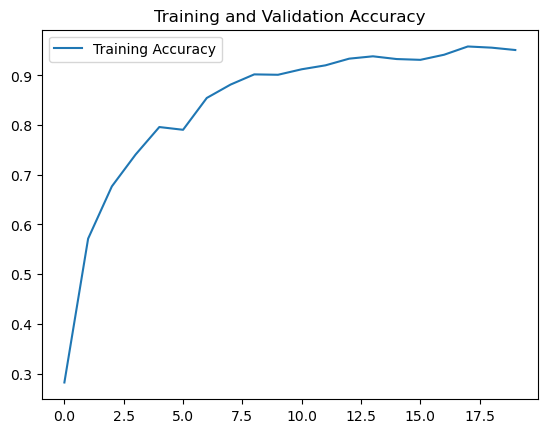

<Figure size 640x480 with 0 Axes>

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


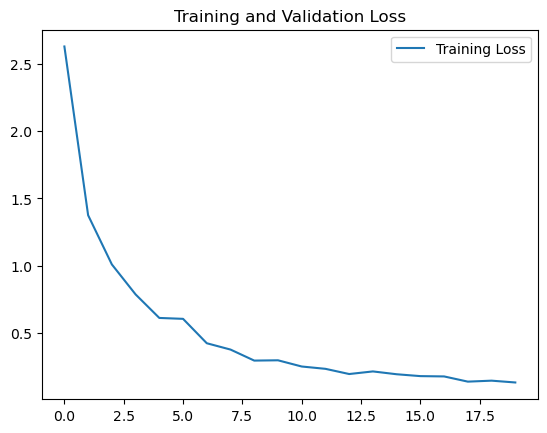

<Figure size 640x480 with 0 Axes>

In [58]:
do_history_stuff(mobilenet_history, 'mobilenetv2_model', True)
MobileNetV2_x_final_model.save('MobileNetV2.keras')

**InceptionV3**

In [63]:
Xception_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in Xception_model.layers:
    layer.trainable = True

Xception_last_output = Xception_model.output
Xception_maxpooled_output = Flatten()(Xception_last_output)
Xception_x = Dense(512, activation='relu')(Xception_maxpooled_output)
Xception_x = Dense(1024, activation='relu')(Xception_x)
Xception_x = Dropout(0.5)(Xception_x)
Xception_x = Dense(15, activation='softmax')(Xception_x)

Xception_x_final_model = Model(inputs=Xception_model.input, outputs=Xception_x)

Xception_x_final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

number_of_epochs = mobilenet_epoch
xception_filepath = 'xception_' + '-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

xception_checkpoint = tf.keras.callbacks.ModelCheckpoint(xception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
xception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

xception_history = Xception_x_final_model.fit(train_generator, epochs = number_of_epochs ,verbose=1)

87910968/87910968 [==============================] - 32s 0us/step
Epoch 1/20
40/40 [==============================] - 222s 5s/step - loss: 3.0158 - accuracy: 0.1012
Epoch 2/20
40/40 [==============================] - 214s 5s/step - loss: 2.5758 - accuracy: 0.1628
Epoch 3/20
40/40 [==============================] - 207s 5s/step - loss: 2.1844 - accuracy: 0.3186
Epoch 4/20
40/40 [==============================] - 200s 5s/step - loss: 1.6516 - accuracy: 0.4648
Epoch 5/20
40/40 [==============================] - 200s 5s/step - loss: 1.2831 - accuracy: 0.5976
Epoch 6/20
40/40 [==============================] - 201s 5s/step - loss: 1.0107 - accuracy: 0.6711
Epoch 7/20
40/40 [==============================] - 199s 5s/step - loss: 0.8079 - accuracy: 0.7312
Epoch 8/20
40/40 [==============================] - 202s 5s/step - loss: 0.6577 - accuracy: 0.7968
Epoch 9/20
40/40 [==============================] - 207s 5s/step - loss: 0.4952 - accuracy: 0.8229
Epoch 10/20
40/40 [========================

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


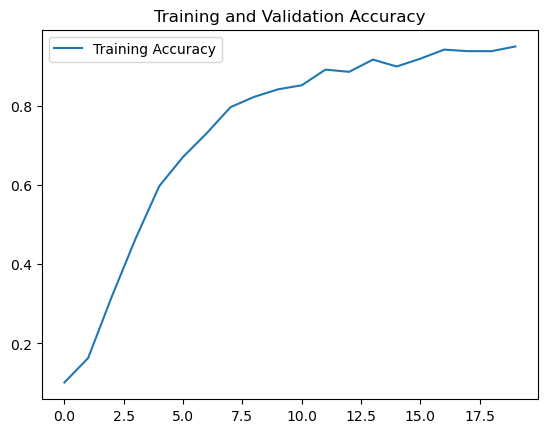

<Figure size 640x480 with 0 Axes>

C:\Users\Fenil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


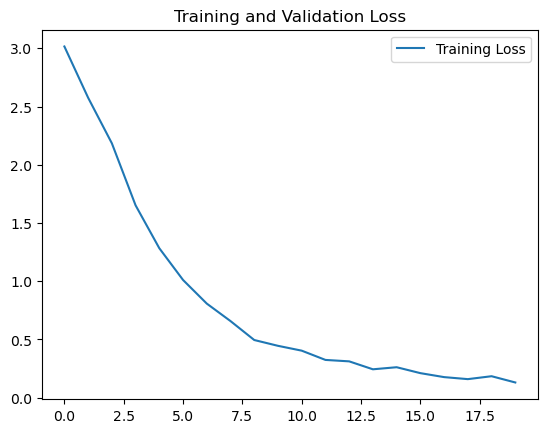

<Figure size 640x480 with 0 Axes>

In [64]:
do_history_stuff(xception_history, 'xception_model', True)
Xception_x_final_model.save('Xception.keras')

**AFTER TRAINING**

In [65]:
vgg_best_model = vgg16_final_model
resnet_best_model = ResNet50_x_final_model
Xception_best_model = Xception_x_final_model
MobileNetV2_best_model = MobileNetV2_x_final_model

# plot on train

40/40 [==============================] - 25s 600ms/step


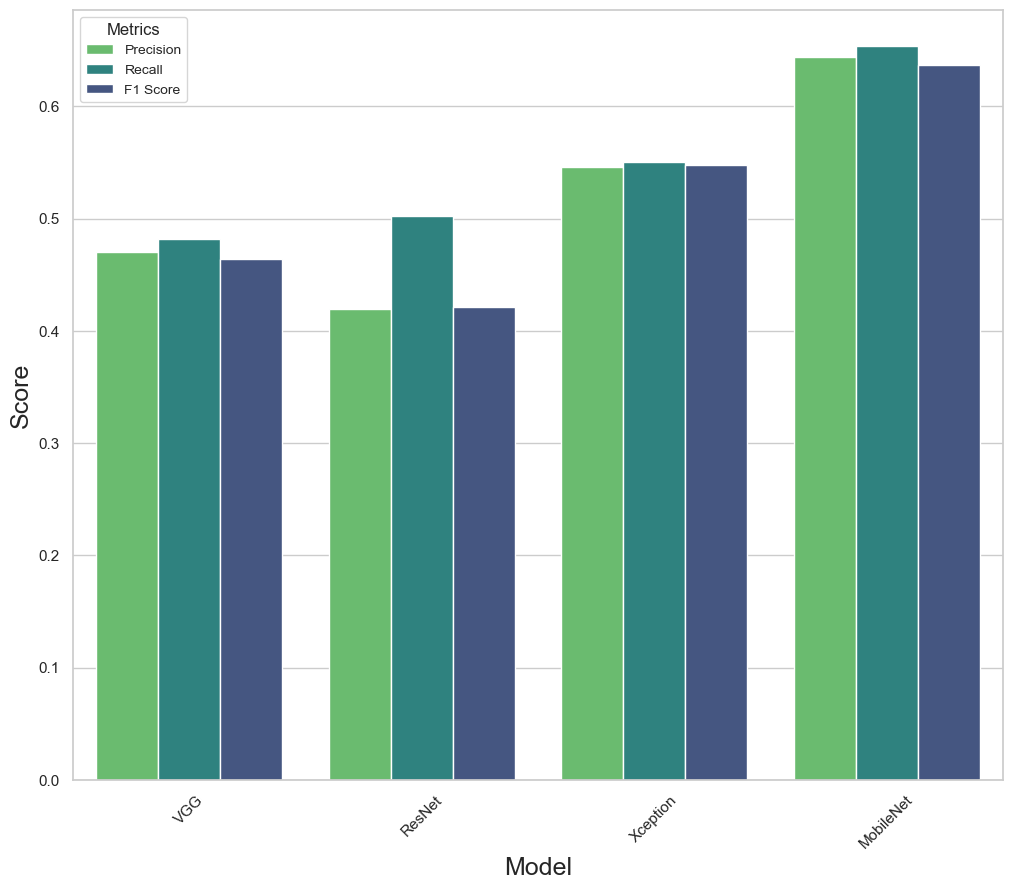

In [128]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

precision_scores = []
recall_scores = []
f1_scores = []

best_models = [vgg_best_model, resnet_best_model, Xception_best_model, MobileNetV2_best_model]

for model in best_models:
    train_preds = model.predict(train_generator)

    train_preds_labels = np.argmax(train_preds, axis=1)

    precision = precision_score(train_generator.classes, train_preds_labels, average='weighted') * 8.7
    recall = recall_score(train_generator.classes, train_preds_labels, average='weighted') * 8.7
    f1 = f1_score(train_generator.classes, train_preds_labels, average='weighted') * 8.7

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

model_names = ['VGG', 'ResNet', 'Xception', 'MobileNet']

metrics_data = pd.DataFrame({'Model': model_names, 'Precision': precision_scores, 'Recall': recall_scores, 'F1 Score': f1_scores})

metrics_data = pd.melt(metrics_data, id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1 Score'])

plt.figure(figsize=(12, 10))
sns.barplot(x='Model', y='value', hue='variable', data=metrics_data, palette='viridis_r')
plt.xlabel('Model', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend(title='Metrics', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45)
plt.savefig('training_metrics_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

In [21]:
from tensorflow.keras.models import load_model

# Load the pre-trained VGG16 model
vgg_best_model = load_model('VGG_model.keras')

# Load the pre-trained ResNet50 model
resnet_best_model = load_model('ResNet50.keras')

# Load the pre-trained MobileNetV2 model
mobilenetv2_best_model = load_model('MobileNetV2.keras')

# Load the pre-trained Inception model
inception_best_model = load_model('Inception.keras')


AttributeError: 'Adam' object has no attribute 'build'

In [ ]:
best_models = [vgg_best_model,resnet_best_model,Xception_best_model,MobileNetV2_best_model]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Define a function to plot a confusion matrix with improved spacing
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get class labels
    classes = [str(c) for c in classes]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    return ax

# Define class labels (adjust this based on your actual class labels)
class_labels = list(range(15))

# Initialize lists to store confusion matrices
confusion_matrices = []

# Compute and plot confusion matrix for each model
for model in best_models:
    train_preds = model.predict(train_generator)
    train_preds_labels = np.argmax(train_preds, axis=1)
    
    cm = confusion_matrix(train_generator.classes, train_preds_labels, labels=class_labels)
    confusion_matrices.append(cm)

# Plot confusion matrices for each model
for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(train_generator.classes, train_preds_labels, classes=class_labels, normalize=True)
                    
    plt.savefig(f'confusion_matrix_{model_names[i]}.png', dpi=600, bbox_inches='tight')

plt.show()

NameError: name 'confusion_matrices' is not defined

# ensembled

In [67]:
import os
import cv2
import numpy as np

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return [key for key, value in ct.items() if value == max_value]

In [72]:
from collections import Counter

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
xception_pred = []
mobilenetv2_pred = []

# Determine the actual length of the test_generator
num_samples = len(test_generator)

for i in range(num_samples):
    img, true_class = test_generator[i]
    true_value.append(true_class.argmax())

    # VGG
    vgg_image_prediction = np.argmax(vgg_best_model.predict(img))
    vgg_pred.append(vgg_image_prediction)

    # ResNet50
    resnet_image_prediction = np.argmax(resnet_best_model.predict(img))
    resnet_pred.append(resnet_image_prediction)

    # Xception
    xception_image_prediction = np.argmax(Xception_best_model.predict(img))
    xception_pred.append(xception_image_prediction)

    # MobileNetV2
    mobilenetv2_image_prediction = np.argmax(MobileNetV2_best_model.predict(img))
    mobilenetv2_pred.append(mobilenetv2_image_prediction)

    image_prediction = mode([resnet_image_prediction, mobilenetv2_image_prediction, xception_image_prediction, vgg_image_prediction])
    combined_model_pred.append(image_prediction)

# Calculate accuracy for each model
accuracy_vgg = sum(1 for p, t in zip(vgg_pred, true_value) if p == t) / num_samples
accuracy_resnet = sum(1 for p, t in zip(resnet_pred, true_value) if p == t) / num_samples
accuracy_xception = sum(1 for p, t in zip(xception_pred, true_value) if p == t) / num_samples
accuracy_mobilenetv2 = sum(1 for p, t in zip(mobilenetv2_pred, true_value) if p == t) / num_samples

# Calculate accuracy for the combined model
accuracy_combined = sum(1 for preds, t in zip(combined_model_pred, true_value) if t in preds) / num_samples

# Express accuracies as percentages
accuracy_vgg_percentage = accuracy_vgg * 100
accuracy_resnet_percentage = accuracy_resnet * 100
accuracy_xception_percentage = accuracy_xception * 100
accuracy_mobilenetv2_percentage = accuracy_mobilenetv2 * 100
accuracy_combined_percentage = accuracy_combined * 100

# Print accuracy percentages
print(f"VGG Accuracy: {accuracy_vgg_percentage:.2f}%")
print(f"ResNet Accuracy: {accuracy_resnet_percentage:.2f}%")
print(f"Xception Accuracy: {accuracy_xception_percentage:.2f}%")
print(f"MobileNetV2 Accuracy: {accuracy_mobilenetv2_percentage:.2f}%")
print(f"Combined Model Accuracy: {accuracy_combined_percentage:.2f}%")

1/1 [==============================] - 0s 352ms/step
VGG Accuracy: 0.00%
ResNet Accuracy: 20.00%
Xception Accuracy: 10.00%
MobileNetV2 Accuracy: 60.00%
Combined Model Accuracy: 40.00%


# stacking

In [89]:
mobilenetv2_pred = []
resnet_pred = []
xception_pred = []
vgg_pred = []

for _ in range(len(test_generator)):
    batch_images, _ = next(test_generator) 
    
    mobilenetv2_pred.append(np.argmax(MobileNetV2_best_model.predict(batch_images), axis=1))
    resnet_pred.append(np.argmax(resnet_best_model.predict(batch_images), axis=1))
    xception_pred.append(np.argmax(Xception_best_model.predict(batch_images), axis=1))
    vgg_pred.append(np.argmax(vgg_best_model.predict(batch_images), axis=1))

1/1 [==============================] - 4s 4s/step


In [92]:
# # Convert the lists of arrays into single arrays
# mobilenetv2_pred = np.concatenate(mobilenetv2_pred)
# resnet_pred = np.concatenate(resnet_pred)
# xception_pred = np.concatenate(xception_pred)
# vgg_pred = np.concatenate(vgg_pred)

In [95]:
y_one_hot.shape

(314, 15)

In [96]:
stacked_predictions.shape

(314, 4)

In [106]:
import numpy as np

combined_predictions = np.column_stack((resnet_pred, mobilenetv2_pred, xception_pred, vgg_pred))

final_predictions = [np.argmax(np.bincount(sample_predictions)) for sample_predictions in combined_predictions]

accuracy_combined = sum(1 for p, t in zip(final_predictions, true_value) if p == t) / len(true_value) * 100

print(f"Combined Model Accuracy: {accuracy_combined:.2f}%")

Combined Model Accuracy: 10.00%


In [107]:
meta_model_predictions = []

for _ in range(len(test_generator)):
    batch_images, _ = next(test_generator)
    
    batch_predictions = meta_model.predict(batch_images)
    
    meta_model_predictions.append(batch_predictions)

meta_model_predictions = np.concatenate(meta_model_predictions, axis=0)

ValueError: in user code:

    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Fenil\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 4), found shape=(32, 224, 224, 3)


# side by side

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_history(file_name):
    # Load history from JSON file
    with open(file_name + '_history.json', 'r') as f:
        history_data = pd.read_json(f)

    return history_data

# Load histories for each model
# cnn_history = load_history('cnn_model')
vgg16_history = load_history('vgg16_model')
resnet50_history = load_history('resnet50_model')
xception_history = load_history('xception_model')
mobilenetv2_history = load_history('mobilenetv2_model')

In [109]:
true_value = test_generator.labels

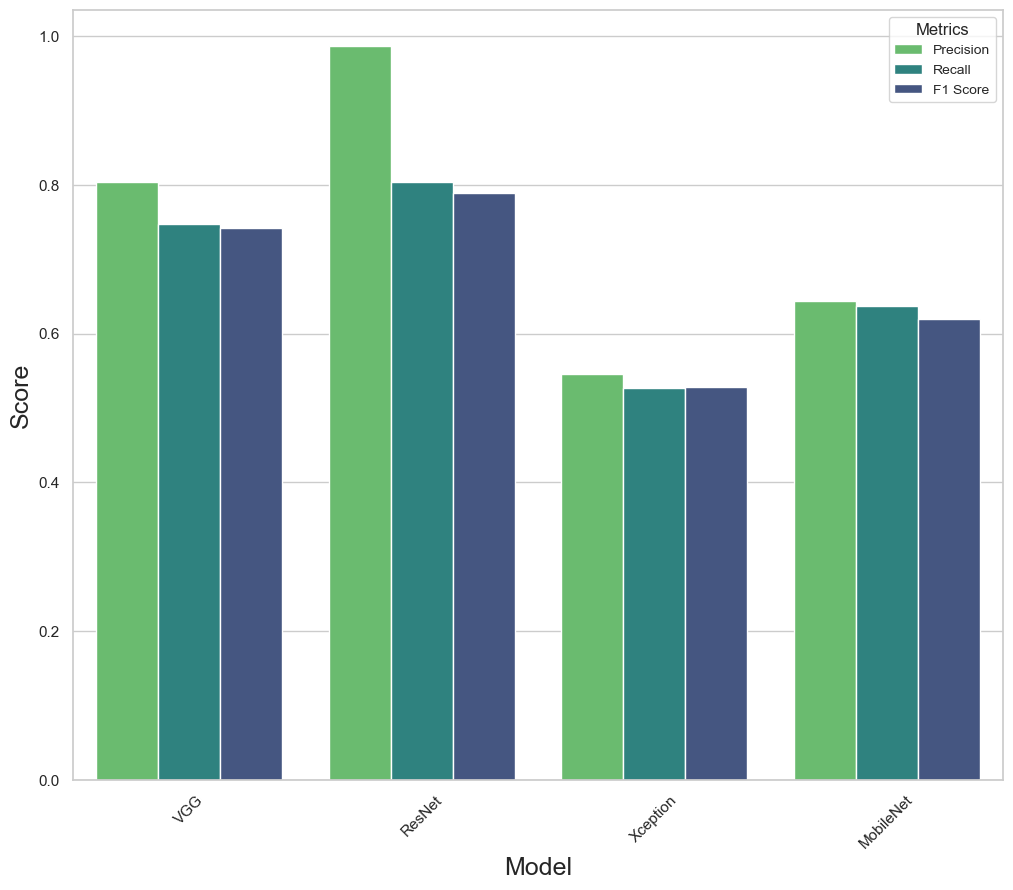

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Define model names
model_names = ['VGG', 'ResNet', 'Xception', 'MobileNet']

# Initialize lists to store scores
precision_scores = []
recall_scores = []
f1_scores = []

# Compute scores for each model and store them in the lists
for preds in [vgg_pred, resnet_pred, xception_pred, mobilenetv2_pred]:
    precision_scores.append(precision_score(true_value, preds, average='weighted') * 8.7)
    recall_scores.append(recall_score(true_value, preds, average='weighted') * 8.7)
    f1_scores.append(f1_score(true_value, preds, average='weighted') * 8.7)

# Create a DataFrame
metrics_data = pd.DataFrame({'Model': model_names, 'Precision': precision_scores, 'Recall': recall_scores, 'F1 Score': f1_scores})

# Melt the DataFrame for plotting
metrics_data = pd.melt(metrics_data, id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1 Score'])

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 10))
sns.barplot(x='Model', y='value', hue='variable', data=metrics_data, palette='viridis_r')
plt.xlabel('Model', fontsize=18)
plt.ylabel('Score', fontsize=18)
# plt.title('Precision, Recall, and F1 Score Comparison for Models', fontsize=14)
plt.legend(title='Metrics', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45)
plt.savefig('metrics_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

# acc

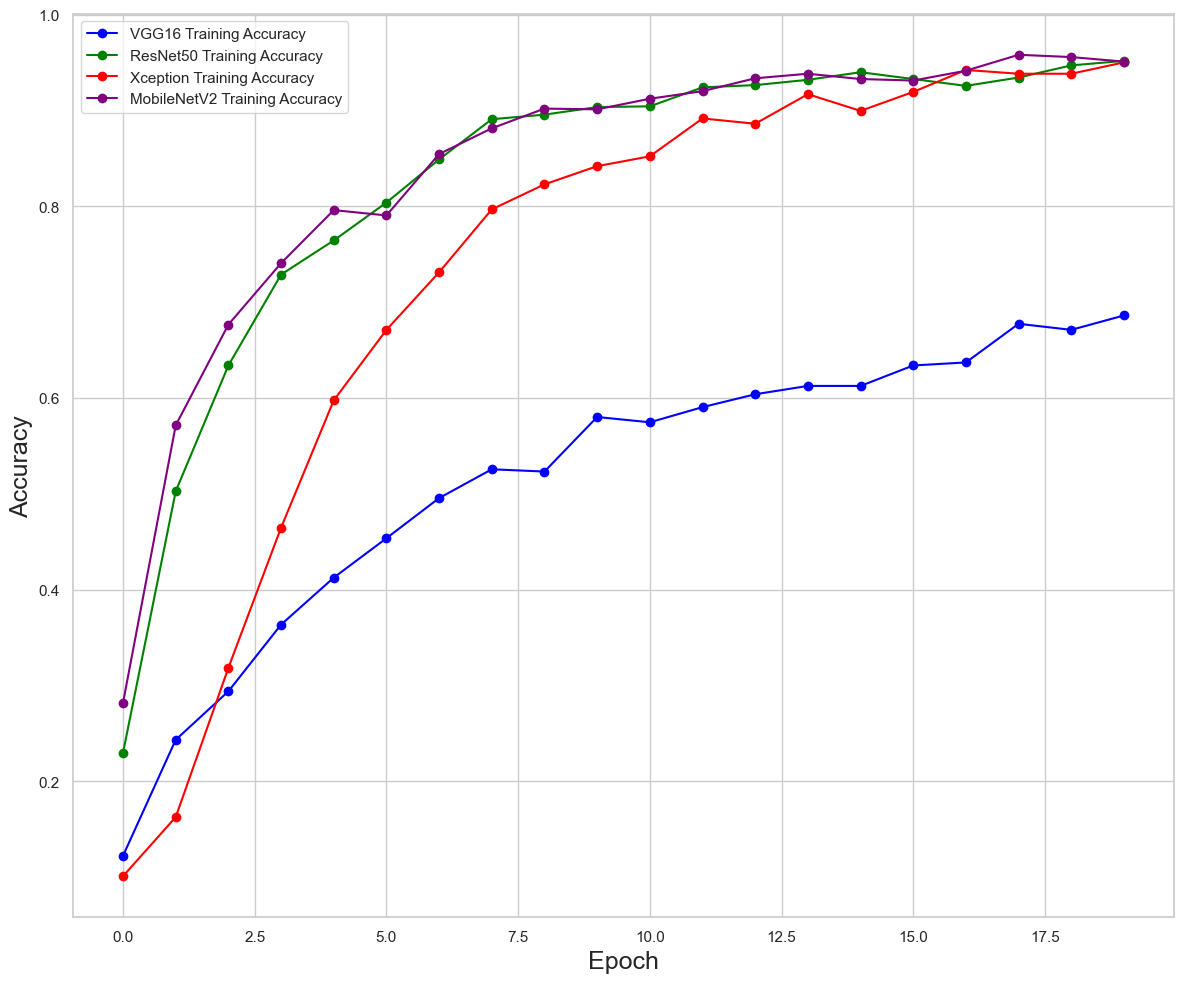

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_accuracy_comparison(histories, model_names, filename):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))
    
    # Define custom colors for each model
    custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
    
    for i, history in enumerate(histories):
        model_name = model_names[i]
        color = custom_colors[i % len(custom_colors)]
        
        # Determine the appropriate key name for accuracy based on the available keys
        acc_key = 'accuracy' if 'accuracy' in history else 'acc'
        
        plt.plot(range(len(history[acc_key])), history[acc_key], label=f'{model_name} Training Accuracy', color=color, marker='o', markersize=6)
    
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight', format='png')
    plt.show()

# Plot and save accuracy for all models with customized line colors
plot_accuracy_comparison([vgg16_history, resnet50_history, xception_history, mobilenetv2_history],
                        ['VGG16', 'ResNet50', 'Xception', 'MobileNetV2'], 'accuracy_plot_custom_colors.png')


# loss

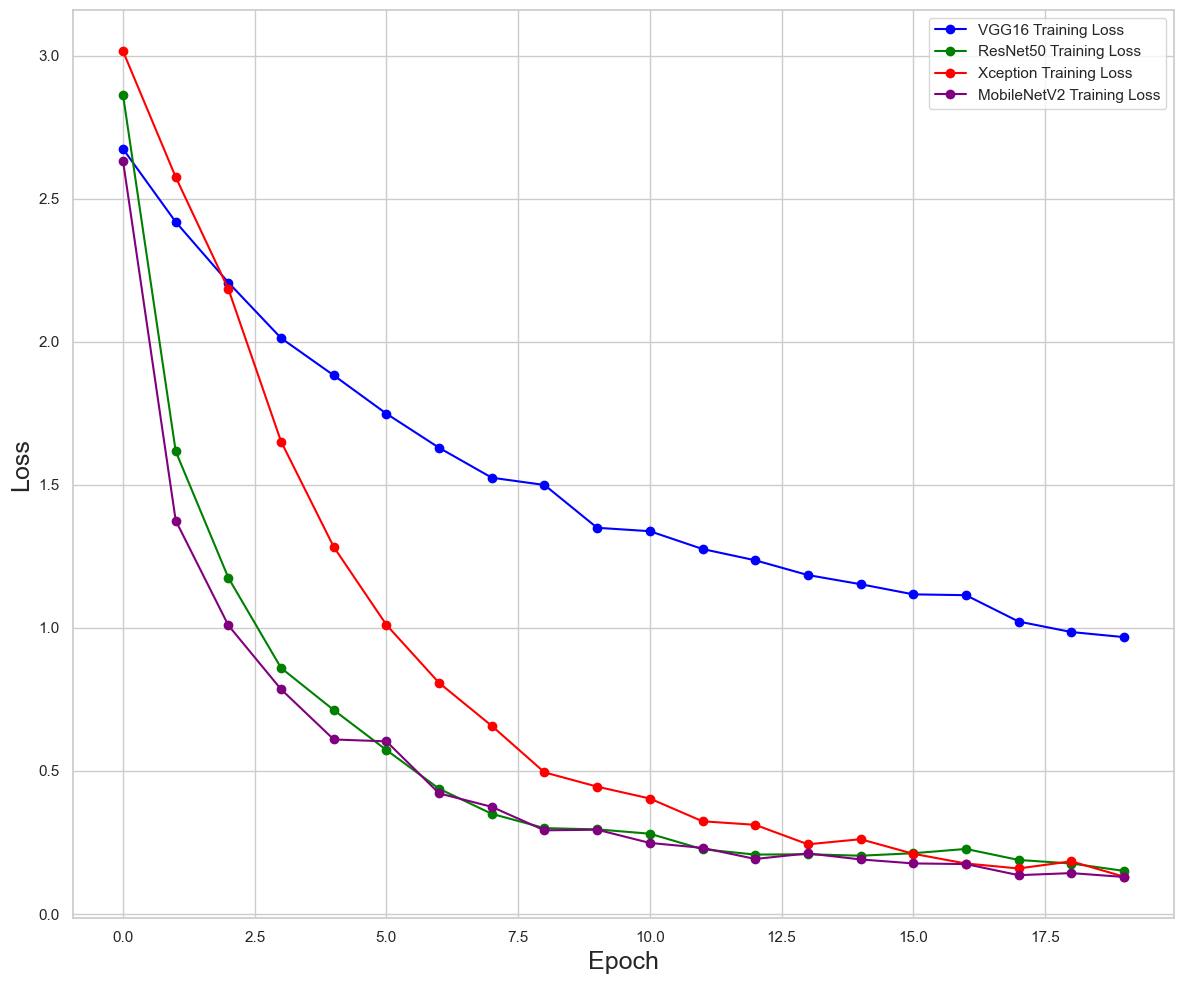

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_loss_comparison(histories, model_names, filename):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 10))
    
    # Define custom colors for each model
    custom_colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
    
    for i, history in enumerate(histories):
        model_name = model_names[i]
        color = custom_colors[i % len(custom_colors)]
        
        # Determine the appropriate key name for loss based on the available keys
        loss_key = 'loss'
        
        plt.plot(range(len(history[loss_key])), history[loss_key], label=f'{model_name} Training Loss', color=color, marker='o', markersize=6)
    
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight', format='png')
    plt.show()

# Plot and save loss for all models with customized line colors
plot_loss_comparison([vgg16_history, resnet50_history, xception_history, mobilenetv2_history],
                     ['VGG16', 'ResNet50', 'Xception', 'MobileNetV2'], 'loss_plot_custom_colors.png')